### 👨‍🏭 Albertus Septian Angkuw

### Pembuatan Call Graph

In [1]:
%pip install pycg

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
currentPath = input()
print('Current Path set:' ,currentPath)

Current Path set: /home/asa/Documents/Skripsi/rancangan-dekomposisi


In [57]:
import os
def walkTroughFolder(folderSC,filterExt='.py'):
    listFile = []
    for file in os.listdir(f'{currentPath}/{folderSC}'):
        if os.path.isdir(f'{currentPath}/{folderSC}/{file}'):
            listFile += walkTroughFolder(f'{folderSC}/{file}')
        elif file.endswith(filterExt):
            #print(os.path.join(f'/{folderSC}', file))
            listFile.append(os.path.join(f'/{folderSC}', file))
    return listFile

In [58]:
folderSC = "asciinema"
os.system(f'py_files=$(find {currentPath}/{folderSC} -type f -name "*.py") && pycg --package {folderSC} $py_files > {folderSC}.json ')

scannedFiles = walkTroughFolder(folderSC)
print(f'Total Files Scanned py Source Code: {len(scannedFiles)}')

Total Files Scanned py Source Code: 31


### Pembacaan Hasil Call Graph JSON

In [4]:
import json
cgFile = open(f'{currentPath}/{folderSC}.json')
cgSource = json.load(cgFile)

In [5]:
list(cgSource.values())[:3]

[['sys.exit', '<builtin>.open', 'setuptools.setup'], [], []]

### Visualisasi Call Graph

In [6]:
%pip install pygraphviz

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
import pygraphviz as pgv
def cobaDot():
    d = {"1": {"2": 7 }, "2": {"1": 1, "3": 1, "5" : 1}}
    A = pgv.AGraph(d,strict=False, directed=True)
    A.layout(prog="dot")
    A.draw(f'{currentPath}/contoh-CG.svg') 
    print(A)

In [39]:
cobaDot()

digraph "" {
	graph [bb="0,0,126,180"];
	node [label="\N"];
	1	[height=0.5,
		pos="63,162",
		width=0.75];
	2	[height=0.5,
		pos="63,90",
		width=0.75];
	1 -> 2	[pos="e,57.121,107.96 57.16,144.41 56.297,136.51 56.048,126.85 56.412,117.94"];
	2 -> 1	[pos="e,68.84,144.41 68.879,107.96 69.714,115.83 69.948,125.37 69.583,134.19"];
	3	[height=0.5,
		pos="27,18",
		width=0.75];
	2 -> 3	[pos="e,35.304,35.147 54.65,72.765 50.288,64.283 44.853,53.714 39.959,44.197"];
	5	[height=0.5,
		pos="99,18",
		width=0.75];
	2 -> 5	[pos="e,90.696,35.147 71.35,72.765 75.712,64.283 81.147,53.714 86.041,44.197"];
}



#### Call Graph Raw

In [40]:
callGraphRaw = {}
for key, value in cgSource.items():
    callGraphRaw[key] = {}
    for v in value:
        callGraphRaw[key][v] = 1

In [41]:
A = pgv.AGraph(callGraphRaw,strict=False, directed=True)
A.layout(prog="fdp")
A.draw(f'{currentPath}/{folderSC}-RAW-CG.svg') 

#### Filter Call diluar Project

In [59]:
callGraphFiltered = {}
edgeGraph = []
outsideCall = set()
for key, value in cgSource.items():
    rootSource = key.split('.')[0]
    if rootSource != folderSC:
        outsideCall.add(rootSource)
        continue
    childFilter = {}
    for v in value:
        childSource = v.split('.')[0]
        if childSource != folderSC:
            outsideCall.add(childSource)
            continue
        childFilter[v] = 1
    if len(childFilter) == 0:
        edgeGraph.append(key)
        continue
    callGraphFiltered[key] = childFilter
    
print(f'Total Top Node: {len(callGraphFiltered)} ')
print(f'Total Edge: {len(edgeGraph)} <{edgeGraph[:3]}>')
print(f'Total OutsideEdge: {len(outsideCall)} <{list(outsideCall)[:3]}>')

Total Top Node: 60 
Total Edge: 101 <['asciinema', 'asciinema.recorder', 'asciinema.term.get_size']>
Total OutsideEdge: 34 <['pty', 'struct', 'configparser']>


In [45]:
A = pgv.AGraph(callGraphFiltered,strict=False, directed=True)
A.layout(prog="fdp")
A.draw(f'{currentPath}/{folderSC}-CG.svg') 

#### Pemberian Weight pada Graph

In [66]:
callGraph = {}
for file in scannedFiles:
    newKey = '.'.join(filter(None,file[:-3].split("/")))
    callGraph[newKey] = {}


{'asciinema.setup': {}, 'asciinema.tests.config_test': {}, 'asciinema.tests.asciicast.v2_test': {}, 'asciinema.tests.asciicast.__init__': {}, 'asciinema.tests.test_helper': {}, 'asciinema.tests.pty_test': {}, 'asciinema.tests.__init__': {}, 'asciinema.asciinema.term': {}, 'asciinema.asciinema.asciicast.v2': {}, 'asciinema.asciinema.asciicast.v1': {}, 'asciinema.asciinema.asciicast.__init__': {}, 'asciinema.asciinema.asciicast.events': {}, 'asciinema.asciinema.asciicast.raw': {}, 'asciinema.asciinema.__main__': {}, 'asciinema.asciinema.pty': {}, 'asciinema.asciinema.recorder': {}, 'asciinema.asciinema.urllib_http_adapter': {}, 'asciinema.asciinema.http_adapter': {}, 'asciinema.asciinema.async_worker': {}, 'asciinema.asciinema.__init__': {}, 'asciinema.asciinema.config': {}, 'asciinema.asciinema.notifier': {}, 'asciinema.asciinema.api': {}, 'asciinema.asciinema.commands.auth': {}, 'asciinema.asciinema.commands.upload': {}, 'asciinema.asciinema.commands.play': {}, 'asciinema.asciinema.com

#### Representasi Call Graph menjadi Adjacency Matrix

In [18]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
def createAdjacentMatrix(graphSource):
    listLabel = {}
    counterListLabel = 0
    for label in graphSource.keys():
        listLabel[label] = counterListLabel
        counterListLabel+=1
    adjMatrix = np.zeros(shape=(len(listLabel), len(listLabel)))

    currRow = 0
    for _, connection in graphSource.items():
        for name, weight in connection.items():
            adjMatrix[currRow,listLabel[name]] = weight
        currRow+=1 
    return adjMatrix, listLabel

In [17]:
#createAdjacentMatrix()

298

In [35]:
currRow = 0
for key, value in cgSource.items():
     while len(value) > 0:
          relation = value.pop()
          adjMatrix[currRow,listLabel[relation]] = 1
     currRow+=1 

In [40]:
np.savetxt(f'{folderSC}-AdjMatrix.csv', adjMatrix, delimiter=",")

#### Clustering

In [48]:
%pip install scipy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 4.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 4.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 4.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [49]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, median, centroid, weighted, average, complete, single, fcluster
from scipy.spatial.distance import pdist

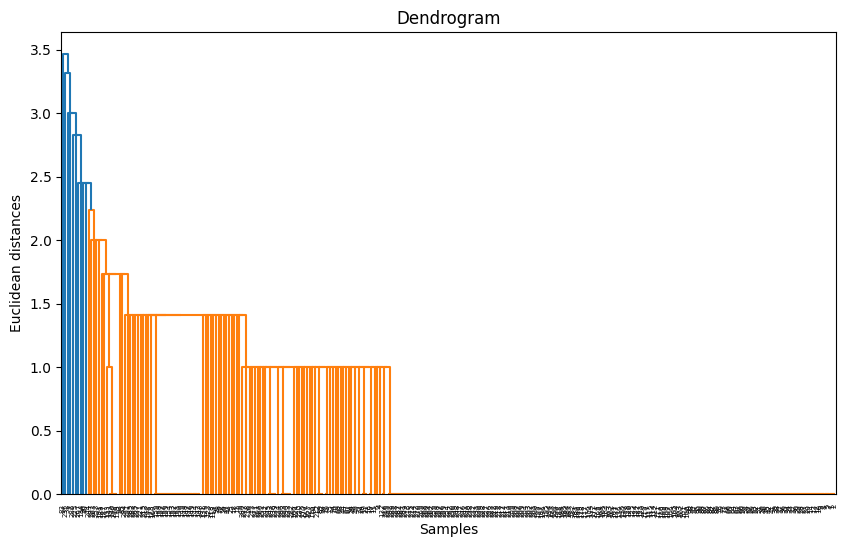

In [50]:
plt.figure(figsize=(10,6))
dend = sch.dendrogram(sch.linkage(adjMatrix, method = 'single'))
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()